<a href="https://colab.research.google.com/github/geoskimoto/AWDB_SOAP_Request/blob/main/GetData_AWDB_SOAP_call.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import requests
import xml.dom.minidom as minidom
import json
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import datetime

def SOAP_Call(stationtriplets, elementCD, begindate, enddate):

  # Create a dictionaries to store the data
  headers = {'Content-type': 'text/soap'}
  # current_dictionary = {}
  
  # Define Web Service URL
  URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"

  # Define Parameters for SOAP Elements (getData:current and getCentralTendencyData:normals)
  SOAP_current = '''
  <?xml version="1.0" encoding="UTF-8"?>
  <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <SOAP-ENV:Body>
      <q0:getData>
        <stationTriplets>$STATIONTRIPLETS$</stationTriplets>
        <elementCd>$ELEMENTCD$</elementCd>   
        <ordinal>1</ordinal>
        <duration>DAILY</duration>
        <getFlags>false</getFlags>
        <beginDate>$BEGINDATE$</beginDate>
        <endDate>$ENDDATE$</endDate>
        <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>   
      </q0:getData>
    </SOAP-ENV:Body>
  </SOAP-ENV:Envelope>

  '''.strip()
  #Read GetData documents - If <alwaysReturnDailyFeb29> is set to true, will set a null for every non leap year on the 29th,  
  #which breaks this request when selecting ranges that include Feb 29.
  #other element codes: PREC, WTEQ (Water Equivalent/SWE)
  

  # Post SOAP Elements to AWDB Web Service and process results - getData
  SOAP_current = SOAP_current.replace("$ELEMENTCD$", elementCD)
  SOAP_current = SOAP_current.replace("$STATIONTRIPLETS$", stationtriplets)
  SOAP_current = SOAP_current.replace("$BEGINDATE$", begindate)
  SOAP_current = SOAP_current.replace("$ENDDATE$", enddate)

  response_current = requests.post(URL, data=SOAP_current, headers=headers)
  xmldoc = minidom.parseString(response_current.text)

  val_length = len(xmldoc.getElementsByTagName('values'))
  data = pd.DataFrame([xmldoc.getElementsByTagName('values')[i].firstChild.data for i in range(0,val_length)])

  date = datetime.datetime.strptime(begindate, "%m/%d/%Y").date()  #https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior; .date() after .strptime just tells it to make it a datetime object.  Def necessary.
  # print(date)
  Date = []                                                       
  for i in range(0, val_length): 
    date += datetime.timedelta(days=1)
    Date.append(str(date))

  # {str(xmldoc.getElementsByTagName('stationTriplet')[0].firstChild.data):{Date[j]:xmldoc.getElementsByTagName('values')[j].firstChild.data} for j in range(3)}

  data['Date'] = Date
  data.columns = [f'{elementCD}','Date']
  # data.rename(columns={0:'SWE'}) #doesn't work for some reason, so renaming with just data.columns
  data.set_index('Date', inplace=True)
  
  data[f'{elementCD}'] = list(map(lambda x: float(x), data[f'{elementCD}']))
  
  return data
  # data.tail(7)

In [132]:
# 471:ID:SNTL
# %%timeit
df = SOAP_Call(stationtriplets='401:OR:SNTL',elementCD='PREC',begindate='2/01/1985',enddate='03/15/1987')
df.sample(7)


,PREC
Date,
1986-02-09,22.8
1985-09-04,39.3
1985-07-08,36.8
1986-11-04,2.4
1986-02-16,23.8
1986-04-15,36.9
1985-05-03,33.6


In [133]:
type(df['PREC'][0])

numpy.float64

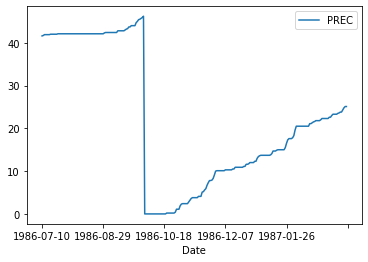

In [140]:
df[-250:].plot()

In [119]:
# list(map(lambda x: str(x), df.iloc[:,0]))

### Multiple issues still:


*   Need a way to select multiple stations at once or iteratively run function
*   Call breaks when selecting different ranges of data. Pretty sure it's around Feb 29/leap years giving null values.
*   Need to fix how the date format and how they are being iteratively added.  Seems to sometime select month instead of day.  Probably why code is breaking in certain cases.
*   Need map(lambda float(x): x] to convert values from strings to floats or int 



